# Setting up environment

In [6]:
import pandas as pd
import numpy as np
import nltk
from nltk.tokenize import sent_tokenize
nltk.download('punkt')
nltk.download('stopwords')
import re
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import nltk
from nltk import FreqDist
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk.collocations import BigramCollocationFinder
from nltk.collocations import BigramAssocMeasures
from nltk.collocations import TrigramCollocationFinder, TrigramAssocMeasures
import matplotlib.pyplot as plt

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
%%capture
!pip install bertopic datasets accelerate bitsandbytes xformers adjustText

# Word Frequency Analysis (Lufthansa)

In [4]:
data = pd.read_csv('combined_airline_review.csv')
data_sub = data[data['Airline'].eq('Lufthansa')]
data_sub = data_sub[data_sub['year']==2023]
sub_reviews = data_sub['Review'].tolist()
#data['Review'] = data['Review'].str.lower().replace('lufthansa', '', regex=False)
#data['Review'] = data['Review'].str.lower().replace('british airway', '', regex=False)
#data['Review'] = data['Review'].str.lower().replace('ba', '', regex=False)

all_sentences = []
for review in sub_reviews:
    # use the sentence tokenizer
    sentences = sent_tokenize(review)
    # split each review into sentences and combine all sentences into a single list
    # all_sentences contains each sentence from every review as a separate element
    all_sentences.extend(sentences)

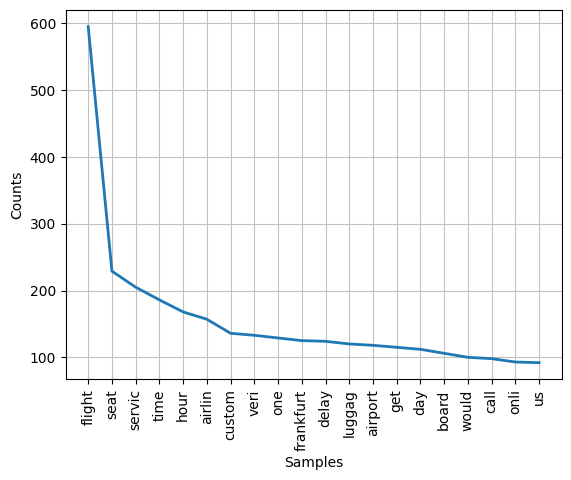

<Axes: xlabel='Samples', ylabel='Counts'>

In [7]:
# Unigram Word Frequency
reviews = [sent.replace('\xa0', '') for sent in all_sentences]
reviews = [sent.replace('\r\n', '') for sent in reviews]
reviews = [re.sub("\'", "", sent) for sent in reviews]
reviews = [re.sub('\W', ' ', sent) for sent in reviews]
reviews = [sent.lower() for sent in reviews]
# add airline's name into stopwrds
stopword = stopwords.words("english")+ ['lufthansa']
snowball_stemmer = SnowballStemmer("english")
# split sentence into words
word_tokens = [nltk.word_tokenize(sent) for sent in reviews]
stemmed_word = [[snowball_stemmer.stem(word) for word in sent] for sent in word_tokens]
c_text = [[word for word in sent if word not in stopword] for sent in stemmed_word]
flat_words = [word for sent in c_text for word in sent]
freq = FreqDist(flat_words)
freq.plot(20)

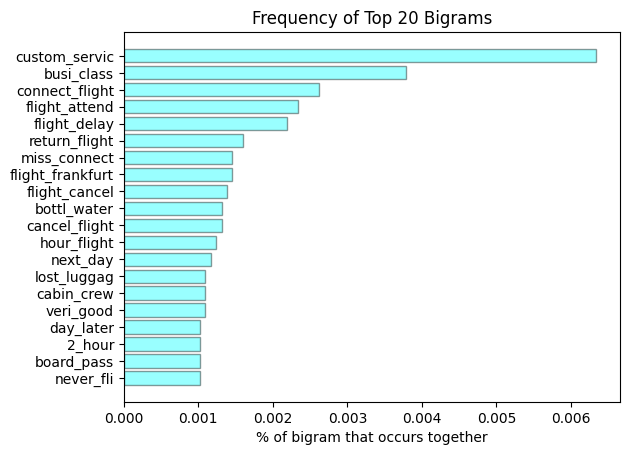

In [8]:
# Bigram Word Analysis

# create a BigramCollocationFinder instance
bigram_finder = BigramCollocationFinder.from_words(flat_words)
# choose a measure to rank the bigrams: frequency
bigram_measures = BigramAssocMeasures()
bigrams = bigram_finder.ngram_fd.items()
bigramFreqTable = pd.DataFrame(list(bigrams), columns=['bigram','freq']).sort_values(by='freq', ascending=False)
bigramFreqTable = bigramFreqTable.reset_index(drop=True)
test_string = bigramFreqTable['bigram'].tolist()
test_string[1][0] +'_' + test_string[1][1]
#combine all tuples in df
bigram = [ ]
for c in range(0, len(test_string)):
    bigram.append(test_string[c][0] +'_' + test_string[c][1])
bigramFreqTable['bigram_combo'] = bigram
# select the top20 to have a glance
top20_bigram = bigramFreqTable[:20]
plt.barh(top20_bigram['bigram_combo'], top20_bigram['freq']/len(data), color ='cyan', alpha = 0.4,
         edgecolor = 'black', linewidth = 1)
plt.xlabel("% of bigram that occurs together")
plt.gca().invert_yaxis()
plt.title("Frequency of Top 20 Bigrams")
plt.show()

We can see the bigram result has more information than the unigram one. Like there are customer service, flight connection, flight delay....

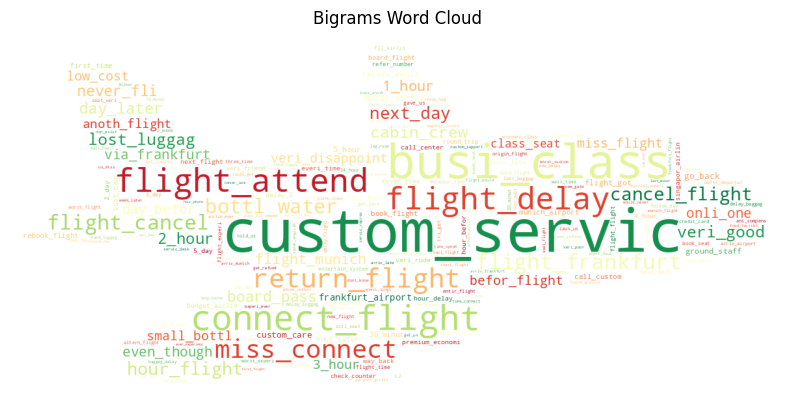

In [10]:
# Visualize the Bigram
bigram_freq_dict = pd.Series(bigramFreqTable.freq.values, index=bigramFreqTable.bigram_combo).to_dict()
mask = np.array(Image.open("mask.png"))
wordcloud = WordCloud(background_color="white", colormap='RdYlGn', mask = mask,).generate_from_frequencies(bigram_freq_dict)
image_colors = ImageColorGenerator(mask)
plt.figure(figsize=(10,8))
plt.imshow(wordcloud)
plt.axis('off')
plt.title('Bigrams Word Cloud')
plt.show()


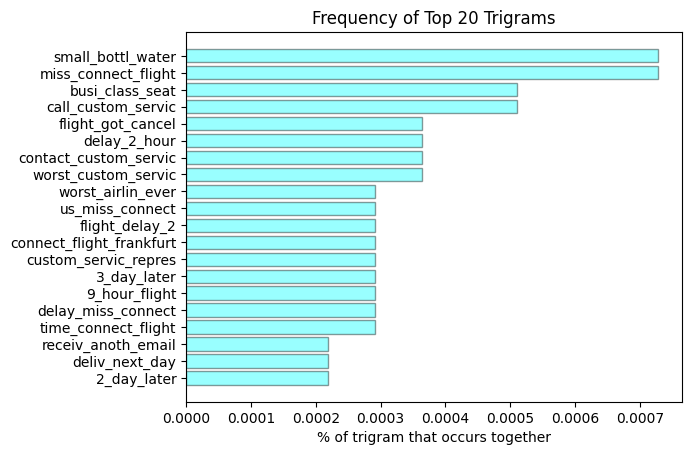

In [11]:
# Trigram Analysis

trigram_finder = TrigramCollocationFinder.from_words(flat_words)
trigram_measures = TrigramAssocMeasures()
trigrams = trigram_finder.ngram_fd.items()
trigramFreqTable = pd.DataFrame(list(trigrams), columns=['trigram', 'freq']).sort_values(by='freq', ascending=False)
trigramFreqTable = trigramFreqTable.reset_index(drop=True)
trigram = []
for c in range(0, len(trigramFreqTable)):
    trigram.append("_".join(trigramFreqTable['trigram'][c]))
trigramFreqTable['trigram_combo'] = trigram
top20_trigram = trigramFreqTable[:20]
plt.barh(top20_trigram['trigram_combo'], top20_trigram['freq'] / len(data), color='cyan', alpha=0.4,
         edgecolor='black', linewidth=1)
plt.xlabel("% of trigram that occurs together")
plt.gca().invert_yaxis()
plt.title("Frequency of Top 20 Trigrams")
plt.show()

Although this is more informative, trigram turns less often to occur. So we don't choose this method. However, we can see 'small bottle water' should be the most concerned issue in food & beverage aspect. Other than this, flight delay and flight cancell bother a lot.

# Topic Modelling (Sentence Review Analysis)

In [12]:
from sentence_transformers import SentenceTransformer
from bertopic import BERTopic
from umap import UMAP
from sklearn.cluster import KMeans
from hdbscan import HDBSCAN
from sklearn.feature_extraction.text import CountVectorizer
from sentence_transformers import SentenceTransformer
import bitsandbytes
from torch import bfloat16
import transformers


# Pre-calculate embeddings
embedding_model = SentenceTransformer("BAAI/bge-small-en")
embeddings = embedding_model.encode(all_sentences, show_progress_bar=True)
vectorizer_model = CountVectorizer(stop_words="english", ngram_range=(2,3)) # use bigram and trigram
umap_model = UMAP(n_neighbors=15, n_components=5, min_dist=0.0, metric='cosine')
cluster_model = KMeans(n_clusters=20)

# Pre-reduce embeddings for visualization purposes
reduced_embeddings = UMAP(n_neighbors=15, n_components=5, min_dist=0.0, metric='cosine', random_state=58).fit_transform(embeddings)

.gitattributes:   0%|          | 0.00/1.52k [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/90.8k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/684 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/133M [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/134M [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/366 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

Batches:   0%|          | 0/73 [00:00<?, ?it/s]

## llama2

In [14]:
from huggingface_hub import notebook_login
notebook_login()

In [15]:
from torch import cuda

model_id = 'meta-llama/Llama-2-7b-chat-hf'
device = f'cuda:{cuda.current_device()}' if cuda.is_available() else 'cpu'

print(device)

In [16]:
# set quantization configuration to load large model with less GPU memory
# this requires the `bitsandbytes` library
bnb_config = transformers.BitsAndBytesConfig(
    load_in_4bit=True,  # 4-bit quantization
    bnb_4bit_quant_type='nf4',  # Normalized float 4
    bnb_4bit_use_double_quant=True,  # Second quantization after the first
    bnb_4bit_compute_dtype=bfloat16  # Computation type
)

# Llama 2 Tokenizer
tokenizer = transformers.AutoTokenizer.from_pretrained(model_id)

# Llama 2 Model
model = transformers.AutoModelForCausalLM.from_pretrained(
    model_id,
    trust_remote_code=True,
    quantization_config=bnb_config,
    device_map='auto',
)
model.eval()

tokenizer_config.json:   0%|          | 0.00/1.62k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.84M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/414 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/614 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/26.8k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/9.98G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/3.50G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/188 [00:00<?, ?B/s]

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(32000, 4096)
    (layers): ModuleList(
      (0-31): 32 x LlamaDecoderLayer(
        (self_attn): LlamaAttention(
          (q_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (v_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (o_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (rotary_emb): LlamaRotaryEmbedding()
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear4bit(in_features=4096, out_features=11008, bias=False)
          (up_proj): Linear4bit(in_features=4096, out_features=11008, bias=False)
          (down_proj): Linear4bit(in_features=11008, out_features=4096, bias=False)
          (act_fn): SiLUActivation()
        )
        (input_layernorm): LlamaRMSNorm()
        (post_attention_layernorm): LlamaRMSNorm()
      )
    )
    (norm

In [17]:
# Our text generator
generator = transformers.pipeline(
    model=model, tokenizer=tokenizer,
    task='text-generation',
    temperature=0.1,
    max_new_tokens=8000,
    repetition_penalty=1.1
)

In [18]:
# System prompt describes information given to all conversations
system_prompt = """
<s>[INST] <<SYS>>
You are a helpful and honest assistant for finding issues from airline reviews.
possible topics may include: seat comfort, cabin crew service, ground facilities, food and beverage, flight delay, groud customer service, wifi, inflight entertainment...
<</SYS>>
"""
# Example prompt demonstrating the output we are looking for
example_prompt = """
I have a topic that contains the following documents which are airline customer reviews:
- Worst customer service of all Airlines. I have never seen employees so rude that can't help resolve simple issues. Everytime there was an issue to arise they always say there is nothing they can do about it. I have booked with them twice and both times have been awful experiences.
- Worst, the customer Service, cabin crew, specially main desk & boarding desk staffs at the airport are rude and unhelpful.
- Customer service is really bad! Takes 40 to 45 minutes to talk to the agent. Incredibly hard to receive refund. No phone to contact a refund team. Not gonna use this airline again.

The topic is described by the following keywords: 'customer service, Worst, cabin crew, rude, unhelpful, hard'.

Based on the information about the topic above, please create a short label of this topic about airline customer reviews. Make sure you to only return the label and nothing more.

[/INST] Bad customer service with rude attitude.
"""
main_prompt = """
[INST]
I have a topic that contains the following documents which are airline customer reviews:
[DOCUMENTS]

The topic is described by the following keywords: '[KEYWORDS]'.

Based on the information about the topic above, please create a short label of this topic about airline customer reviews. Make sure you to only return the label and nothing more.
Do not just give a general label such as lufthansa flight experiences, but be more specific and give the positive sides or negative issues.
[/INST]
"""
prompt = system_prompt + example_prompt + main_prompt

In [19]:
from bertopic.representation import KeyBERTInspired, MaximalMarginalRelevance, TextGeneration

# KeyBERT
keybert = KeyBERTInspired()

# Text generation with Llama 2
llama2 = TextGeneration(generator, prompt=prompt)

# All representation models
representation_model = {
    "KeyBERT": keybert,
    "Llama2": llama2,
}

topic_model = BERTopic(min_topic_size=4,
                       language="english",
                       calculate_probabilities=True,
                       verbose=True,
                       umap_model=umap_model,
                       hdbscan_model=cluster_model,
                       representation_model=representation_model,
                       embedding_model = 'multi-qa-mpnet-base-dot-v1',
                       vectorizer_model=vectorizer_model)

In [20]:
topics, probs= topic_model.fit_transform(all_sentences)

2024-01-17 22:02:19,439 - BERTopic - Embedding - Transforming documents to embeddings.


.gitattributes:   0%|          | 0.00/737 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/8.66k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

data_config.json:   0%|          | 0.00/25.5k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

train_script.py:   0%|          | 0.00/13.9k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

Batches:   0%|          | 0/73 [00:00<?, ?it/s]

2024-01-17 22:02:37,501 - BERTopic - Embedding - Completed ✓
2024-01-17 22:02:37,506 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2024-01-17 22:03:01,608 - BERTopic - Dimensionality - Completed ✓
2024-01-17 22:03:01,613 - BERTopic - Cluster - Start clustering the reduced embeddings
2024-01-17 22:03:03,375 - BERTopic - Cluster - Completed ✓
2024-01-17 22:03:03,397 - BERTopic - Representation - Extracting topics from clusters using representation models.
100%|██████████| 20/20 [01:55<00:00,  5.76s/it]
2024-01-17 22:05:02,382 - BERTopic - Representation - Completed ✓


In [21]:
result = topic_model.get_topic_info()
result

,Topic,Count,Name,Representation,KeyBERT,Llama2,Representative_Docs
0,0,193,0_lost luggage_lost bag_received email_lost ba...,"[lost luggage, lost bag, received email, lost ...","[luggage came, luggage arrived, missing luggag...","[Lost luggage saga with unexpected arrival., ,...","[Surprise, surprise 1 bag had been delivered t..."
1,1,193,1_worst airline_customer service_worst custome...,"[worst airline, customer service, worst custom...","[perfectly fine airline, expensive airline, wo...",[Disappointing Premium Airline Experience with...,[I watched staff transacting a drink with the ...
2,2,186,2_fly lufthansa_business class_lufthansa busin...,"[fly lufthansa, business class, lufthansa busi...","[flying lufthansa, travelling lufthansa, flown...","[Disappointing Business Class Experience, , , ...","[I would never fly Lufthansa again., Never fly..."
3,3,184,3_business class_seats available_basinet seat_...,"[business class, seats available, basinet seat...","[business class seating, business class seats,...","[Comfort issues in business class., , , , , , ...",[Business class - only one person at gate chec...
4,4,161,4_bottle water_small bottle_small bottle water...,"[bottle water, small bottle, small bottle wate...","[food offered, flight dinner, piece chocolate ...",[Inadequate in-flight service with limited off...,[We were given a small bottle of water and a t...
5,5,149,5_customer service_phone calls_customer relati...,"[customer service, phone calls, customer relat...","[contacting customer service, help tried, don ...",[Frustrating customer service experience with ...,[During the calls they constantly ask you for ...
6,6,148,6_disappointing experience_sense urgency_good ...,"[disappointing experience, sense urgency, good...","[good experience, recommend extremely disappoi...","[Positive Experience with Some Drawbacks, , , ...","[As a result, I am writing this review from th..."
7,7,128,7_days later_cancelled flight_flight attendant...,"[days later, cancelled flight, flight attendan...","[flight cancelled, cancelled flight, canceled ...","[Mixed experiences with poor communication., ,...","[After an hour, she rebooked me for that fligh..."
8,8,119,8_customer service_lufthansa customer service_...,"[customer service, lufthansa customer service,...","[lufthansa customer service, complained luftha...",[Poor customer service and rebooking experienc...,[I bypassed them both in the end by reaching o...
9,9,116,9_flight delayed_connecting flight_flights del...,"[flight delayed, connecting flight, flights de...","[flight delayed, flight flight delayed, flight...","[Flight delays and missed connections., , , , ...",[Flight was delayed by about 60+ mins on the d...


In [24]:
# Visualize the topics
document_list = ["Document " + str(i) for i in range(1, (len(all_sentences)+1))]
llama2_labels = [label[0][0].split("\n")[0] for label in topic_model.get_topics(full=True)["Llama2"].values()]
topic_model.set_topic_labels(llama2_labels)
topic_model.visualize_documents(document_list, reduced_embeddings=reduced_embeddings, hide_annotations=True, hide_document_hover=False, custom_labels=True)

## Utilize Llama2 Generator to give more detailed analysis on a review basis

In [44]:
# System prompt describes information given to all conversations
system_prompt = """
<s>[INST] <<SYS>>

As a helpful text summary assistant, your tasks are:
1. Tell which topics are related to this review. Pre-defined topics include: Seat Comfort, Cabin Staff Service, Food & Beverages, Inflight Entertainment, Ground Service,Wifi & Connectivity, Delay & Cancellation
2. Generate the main labels related to each potential topic, don't too specific, also don't too general
Your goal is to pinpoint the main negative issues or positive compliments highlighted in the reviews.
<</SYS>>
"""

# Example prompt demonstrating the output we are looking for
example_prompt = """
I have an example that contains the following sentences:
My experience with economy class seating comfort on the recent flight has been completely appalling. I have submitted my feedback to Lufthansa, and for this I have received a copy-pasted template response that have denied my request to compensation when I have not made or implied this request any at any point. \
Lufthansa made it clear that the comfort experience was as-intended by the company.
\The crux of the issue was lack of upper body ergonomics in the seats - while there was decent legroom provided, there was no way to rest my upper body without disturbing the passengers next to me, no matter how I tried to contort and what sitting poses I would pick.
\At its root, there is just not enough space between you and the forward seat ahead when it is reclined (which it will be on a long transatlantic flight!), the arm rests were useless, the angles between your body and seats/walls were uncomfortable, and the seating surface was just a bit too short.
\Additionally, the in-flight entertainment gets a low rating due to brightness issue compounded by lack of space - if the IFE screen is off, any time you try to move in your seat you will bump against it... at which point the screen comes back on at default brightness.
\This means it'll shine bright in your face and disturb people around you many-many times over on a dark flight.
\The default brightness is extremely bright for a dark flight condition when everyone is trying to sleep, and there seemed to be no way to make the IFE remember the brightness level.
\I did not use IFE for its intended entertainment purpose, so I cannot rate the media contents.
\The second short flight using A321neo was just OK.
\It provided the basic level of comfort, but was nothing to write home about.
\The other aspects of my flight were not notable in the context of just how very uncomfortable the seating was.one meal on a 10.30 hours long flight.

The output should be:
Seat Comfort:
Negative Labels: Appalling, lack of upper body ergonomics, not enough space between seats, uncomfortable angles, short seating surface.
Neutral Labels: Decent legroom, armrests were useless.
Positive Labels: N/A.

Cabin Staff Service:
Negative Labels: Template response, denied compensation, company intention not to improve comfort.
Neutral Labels: N/A.
Positive Labels: N/Ad.

Inflight Entertainment:
Negative Labels: Brightness issue, lack of space, disturbance due to IFE screen, default brightness too bright, inability to adjust brightness.
Neutral Labels: IFE screen off.
Positive Labels: N/A.

Food & Beverages:
Negative Labels: Mention of only one meal on a long flight.
Neutral Labels: N/A.
Positive Labels: N/A.

Ground Service:
Negative Labels: N/A.
Neutral Labels: N/A.
Positive Labels: N/A.

Wifi & Connectivity:
Negative Labels: N/A.
Neutral Labels: N/A.
Positive Labels: N/A.

Delay & Cancellation:
Negative Labels: N/A.
Neutral Labels: N/A.
Positive Labels: N/A.

Make sure only return related topics, negative labels, netural labels, positive labels, if there isn't related content, write N/A.

[/INST]
"""

# Our main prompt with documents ([DOCUMENTS]) and keywords ([KEYWORDS]) tags
main_prompt = """
[INST]
I have this review:

{text}

Make sure return should be in following format, if there is no related content, write N/A. Make sure the labels are\
not too general, also not too specific, plz output a interpretable sentence:
Seat Comfort:
Negative Labels:
Neutral Labels:
Positive Labels:

Cabin Staff Service:
Negative Labels:
Neutral Labels:
Positive Labels:

Inflight Entertainment:
Negative Labels:
Neutral Labels:
Positive Labels:

Food & Beverages:
Negative Labels:
Neutral Labels:
Positive Labels:

Ground Service:
Negative Labels:
Neutral Labels:
Positive Labels:

Wifi & Connectivity:
Negative Labels:
Neutral Labels:
Positive Labels:

Delay & Cancellation:
Negative Labels:
Neutral Labels:
Positive Labels:

[/INST]
"""

In [45]:
generator = transformers.pipeline(
    model=model, tokenizer=tokenizer,
    task='text-generation',
    temperature=0.1,
    max_new_tokens=500,
    repetition_penalty=1.1,
    return_full_text=False
)
review_test = data.Review[1]
main_ = main_prompt.format(text=review_test)
full_prompt = system_prompt +example_prompt + main_
output = generator(full_prompt)

In [50]:
output[0]['generated_text']

'\nSeat Comfort:\nNegative Labels: None\nNeutral Labels: Small washroom\nPositive Labels: Good order & comfortable seats\n\nCabin Staff Service:\nNegative Labels: None\nNeutral Labels: Friendly & professional\nPositive Labels: None\n\nInflight Entertainment:\nNegative Labels: None\nNeutral Labels: IFE screen off\nPositive Labels: None\n\nFood & Beverages:\nNegative Labels: Limited menu options\nNeutral Labels: None\nPositive Labels: None\n\nGround Service:\nNegative Labels: None\nNeutral Labels: None\nPositive Labels: Helpful ground staff member\n\nWifi & Connectivity:\nNegative Labels: None\nNeutral Labels: None\nPositive Labels: None\n\nDelay & Cancellation:\nNegative Labels: Flight delay due to staffing issue at LHR\nNeutral Labels: Frequent updates from flight manager & flight deck\nPositive Labels: None\n\nNote: Since the reviewer mentioned only positive things about their flight experience, all labels are marked as "Positive Labels".'

In [51]:
data.Review[1]

'Overall very satisfied. Ground staff member at YVR was extremely helpful & courteous. A350 was only a few months old, so seats were in good order & comfortable by the standards of a modern day Y class seat, although the very small washroom was already starting to look a bit shabby. Cabin crew very friendly & professional, & meal service carried out at reasonable time in the flight. Choice of 2 options for the main meal which was the same for both legs of my journey 1 month apart. Flight departed on time but unfortunately upon landing at LHR we were unable to deplane for quite some time due to a staffing issue at LHR which so not the fault of the airline, and we were given frequent updates on the situation from the flight manager & the flight deck.'

In [ ]:
"""

Seat Comfort:
Negative Labels: None
Neutral Labels: Small washroom
Positive Labels: Good order & comfortable seats

Cabin Staff Service:
Negative Labels: None
Neutral Labels: Friendly & professional
Positive Labels: None

Inflight Entertainment:
Negative Labels: None
Neutral Labels: IFE screen off
Positive Labels: None

Food & Beverages:
Negative Labels: Limited menu options
Neutral Labels: None
Positive Labels: None

Ground Service:
Negative Labels: None
Neutral Labels: None
Positive Labels: Helpful ground staff member

Wifi & Connectivity:
Negative Labels: None
Neutral Labels: None
Positive Labels: None

Delay & Cancellation:
Negative Labels: Flight delay due to staffing issue at LHR
Neutral Labels: Frequent updates from flight manager & flight deck
Positive Labels: None

Note: Since the reviewer mentioned only positive things about their flight experience, all labels are marked as "Positive Labels".
"""

We can see this generator Llama2 can detailed split the positive and negative topics in a review, but it needs lots of computing resource. If user is particular interested in part pf reviews and would like to get a detailed analysis, this method works the best.

# END